# DenseNet与ResNeXt

## 1. DenseNet的结构
DenseNet的每一层都都与前面层相连，实现了特征重用。

下图表示一个DenseBlock
![DenseBlock](pics/denseblock.png)

如图所示,在一个DenseBlock中,第i层的输入不仅与i-1层的输出相关,还有所有之前层的输出有关.记作:

![output](pics/ttt.png)

## 2. DenseNet网络的搭建

#### Growth_rate
在一个DenseBlock里面，每个非线性变换H输出的channels数为恒定的Growth_rate，那么第i层的输入的channels数便是k+（i+1）* Growth_rate, k为Input的

channels数，比如，假设我们把Growth_rate设为4，上图中H1的输入的size为8 * 32 * 32，输出为4 * 32 * 32， 则H2的输入的size为12 * 32 * 32，输出还是

4 * 32 * 32，H3、H4以此类推，在实验中，用较小的Growth_rate就能实现较好的效果。

#### Transition Layer
请注意， 在一个DenseBlock里面，feature size并没有发生改变，因为需要对不同层的feature map进行concatenate操作，这需要保持相同的feature size。

因此在相邻的DenseBlock中间使用Down Sampling来增大感受野，即使用Transition Layer来实现，一般的Transition Layer包含BN、Conv和Avg_pool，

同时减少维度，压缩率(compress rate)通常为0.5， 即减少一半的维度。

![DenseNet](pics/densenet.png)

例如，假设block1的输出c * w * h是24 * 32 * 32，那么经过transition之后，block2的输入就是12 * 16 * 16。

#### Bottleneck
为了减少参数和计算量，DenseNet的非线性变换H采用了Bottleneck结构      

BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)，1×1的卷积用于降低维度，将channels数降

低至4 * Growth_rate。

## 3. 网络搭建

### 3.1. 引入需要的package

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os

### 3.2. 定义Transition Layer、Bottleneck

#### Transition Layer

In [2]:
class Transition(nn.Module):
    '''
        transition layer is used for down sampling the feature
        
        when compress rate is 0.5, out_planes is a half of in_planes
    '''
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        
        out = self.conv(F.relu(self.bn(x)))
        # use average pooling change the size of feature map here
        out = F.avg_pool2d(out, 2)
        return out 

#### Bottleneck

In [3]:
class Bottleneck(nn.Module):
    '''
        the above mentioned bottleneck, including two conv layer, one's kernel size is 1×1, another's is 3×3

        after non-linear operation, concatenate the input to the output
    '''
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        
        # input and output are concatenated here
        out = torch.cat([out,x], 1)
        return out

### 3.3. 定义DenseNet

#### DenseNet

In [4]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=24, reduction=0.5, num_classes=12):
        super(DenseNet, self).__init__()
        '''
        Args:
            block: bottleneck
            nblock: a list, the elements is number of bottleneck in each denseblock
            growth_rate: channel size of bottleneck's output
            reduction: 
        '''
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)
        
        # a DenseBlock and a transition layer
        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes
        
        # a DenseBlock and a transition layer
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # a DenseBlock and a transition layer
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # only one DenseBlock 
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        # the last part is a linear layer as a classifier
        self.bn = nn.BatchNorm2d(num_planes)
        # self.linear = nn.Linear(num_planes * 5 * 5, num_classes) !!!
        
        # 3 fc as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_planes * 5 * 5, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        
        # number of non-linear transformations in one DenseBlock depends on the parameter you set
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        # out = self.linear(out) !!!
        out = self.classifier(out)
        return out

#### 根据参数定义所需的DenseNet

In [5]:
def densenet(args):
    '''args is a list for the number of layers'''
    return DenseNet(Bottleneck, args)

In [6]:
densenet([2, 5, 4, 6])

DenseNet(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(72, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (trans1): Transition(
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## 4. 自定义dataset、划分训练集和验证集

### 4.1. 自定义Dataset

#### Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import PIL

class MyDataset(Dataset):
    def __init__(self, labels, root, subset=False, transform=None):
        self.labels = labels
        self.root = root
        self.transform = transform
        
    def __getitem__(self, idx):
        # iloc[i, c]: get the i_th data in c column
        img_name = self.labels.iloc[idx, 0]
        # get full path
        full_name = os.path.join(self.root, img_name)
        # open img as RGB
        image = PIL.Image.open(full_name).convert('RGB')
        
        labels = self.labels.iloc[idx, 2]
        
        if self.transform != None:
            image = self.transform(image)
            
        return image, int(labels)
    
    def __len__(self):
        return len(self.labels)

#### 定义目录、标签

In [8]:
import os
data_dir = './data/'

classes = os.listdir(data_dir + 'train/')
classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

#### 定义训练数据的结构

In [9]:
import pandas as pd
train = []
for index, label in enumerate(classes):
    path = data_dir + 'train/' + label + '/'
    for file in os.listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 

### 4.2. 随机分离训练集和验证集

In [27]:
train_data = df.sample(frac=0.7)
valid_data = df[~df['file'].isin(train_data['file'])]

### 4.3. 定义transform、dataset、dataloader

In [28]:
image_size = 160
batch_size = 32

In [29]:
import torchvision.transforms as transforms

train_trans = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_trans = transforms.Compose([
    transforms.Resize(192),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = MyDataset(train_data, data_dir + 'train/', transform = train_trans)
valid_set = MyDataset(valid_data, data_dir + 'train/', transform = valid_trans)
# test_set = MyDataset(sample_submission, data_dir + 'test/', transform = valid_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
# test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

#### 记录数据集size

In [30]:
dataset_sizes = {
    'train': len(train_loader.dataset), 
    'valid': len(valid_loader.dataset)
}

## 5. 训练与测试

### 5.1. 作图

In [10]:
import matplotlib.pyplot as plt
import numpy as np
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

### 5.2. 训练函数

In [11]:
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable


def train(epoch, model, lossFunction, optimizer, device, trainloader):
    """train model using loss_fn and optimizer. When this function is called, model trains for one epoch.
    Args:
        train_loader: train data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        get_grad: True, False
    output:
        total_loss: loss
        average_grad2: average grad for hidden 2 in this epoch
        average_grad3: average grad for hidden 3 in this epoch
    """
    print('\nEpoch: %d' % (epoch + 1))
    model.train()     # enter train mode
    train_loss = 0    # accumulate every batch loss in a epoch
    correct = 0       # count when model' prediction is correct i train set
    total = 0         # total number of prediction in train set
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # load data to gpu device
        # inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()            # clear gradients of all optimized torch.Tensors'
        outputs = model(inputs)          # forward propagation return the value of softmax function
        loss = lossFunction(outputs, targets) #compute loss
        loss.backward()                  # compute gradient of loss over parameters 
        optimizer.step()                 # update parameters with gradient descent 

        train_loss += loss.item()        # accumulate every batch loss in a epoch
        _, predicted = outputs.max(1)    # make prediction according to the outputs
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() # count how many predictions is correct
    
    return (train_loss * 1.0 / (len(trainloader)))

### 5.3. 测试（评估）函数

In [12]:
def eval(model, lossFunction, optimizer, device, testloader):
    """
    test model's prediction performance on loader.  
    When thid function is called, model is evaluated.
    Args:
        loader: data for evaluation
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
    output:
        total_loss
        accuracy
    """
    global best_acc
    model.eval() #enter test mode
    test_loss = 0 # accumulate every batch loss in a epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = lossFunction(outputs, targets) #compute loss

            test_loss += loss.item() # accumulate every batch loss in a epoch
            _, predicted = outputs.max(1) # make prediction according to the outputs
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # count how many predictions is correct
            
        accuracy = correct*100.0 / total
        test_loss = test_loss * 1.0 / (len(testloader))
        
    return accuracy, test_loss

### 5.4. 拟合函数

In [13]:
def fit(model, num_epochs, optimizer, trainloader, val_loader, device):
    model.to(device)
    if device == 'cuda:1':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    # define the loss function and optimizer

    lossFunction = nn.CrossEntropyLoss()
    
    lossFunction.to(device)
    
    train_losses = []
    val_accs = []
    val_losses = []
    
    for epoch in range(num_epochs):
        tr_loss = train(epoch, model, lossFunction, optimizer, device, trainloader)
        
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch+1, \
                                                                num_epochs, tr_loss)
        print(message)
        
        val_accuracy, val_loss = eval(model, lossFunction, optimizer, device, val_loader)
        
        message = 'Epoch: {}/{}. Validation set: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(epoch+1, \
                                                                num_epochs, val_loss, val_accuracy)
        print(message)
        
        train_losses.append(tr_loss)
        val_accs.append(val_accuracy)
        val_losses.append(val_loss)
        
#         if (epoch + 1) % 5 == 0 :
#             lr = lr / 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
        
    # show curve
    show_curve(train_losses, "train loss")
    show_curve(val_losses, "validation loss")
    show_curve(val_accs, "validation accuracy")
    
    return model

## 6. 训练模型

### 6.1. 初始化参数

In [14]:
num_epochs = 10
lr = 5e-6
momentum = 0.9
weight_decay = 5e-6

In [15]:
# load model into GPU device
if torch.cuda.is_available():
    device = torch.device('cuda:1')  
else:
    device = torch.device('cpu') 
# device = 'cpu'
args = [2, 5, 4, 6]

In [20]:
Densenet_model = densenet(args)

In [39]:
optimizer = optim.SGD(Densenet_model.parameters(), 
                          lr=lr, 
                          momentum=momentum, 
                          weight_decay=weight_decay)

### 6.2. 训练模型


Epoch: 1
Epoch: 1/10. Train set: Average loss: 0.4521
Epoch: 1/10. Validation set: Average loss: 0.2200, Accuracy: 93.5439%

Epoch: 2
Epoch: 2/10. Train set: Average loss: 0.4645
Epoch: 2/10. Validation set: Average loss: 0.2175, Accuracy: 93.7544%

Epoch: 3
Epoch: 3/10. Train set: Average loss: 0.4585
Epoch: 3/10. Validation set: Average loss: 0.2215, Accuracy: 93.1930%

Epoch: 4
Epoch: 4/10. Train set: Average loss: 0.4528
Epoch: 4/10. Validation set: Average loss: 0.2176, Accuracy: 93.5439%

Epoch: 5
Epoch: 5/10. Train set: Average loss: 0.4489
Epoch: 5/10. Validation set: Average loss: 0.2167, Accuracy: 93.4035%

Epoch: 6
Epoch: 6/10. Train set: Average loss: 0.4495
Epoch: 6/10. Validation set: Average loss: 0.2184, Accuracy: 93.6140%

Epoch: 7
Epoch: 7/10. Train set: Average loss: 0.4507
Epoch: 7/10. Validation set: Average loss: 0.2224, Accuracy: 93.4035%

Epoch: 8
Epoch: 8/10. Train set: Average loss: 0.4848
Epoch: 8/10. Validation set: Average loss: 0.2196, Accuracy: 93.6140%


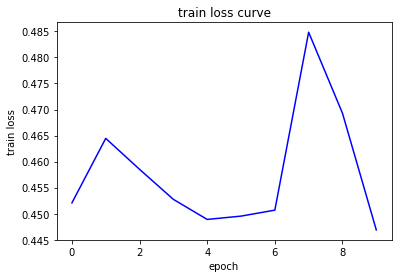

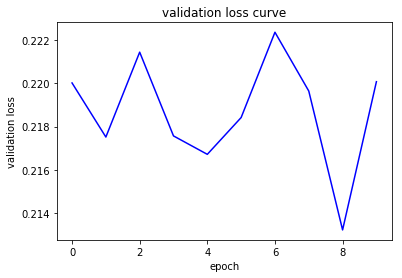

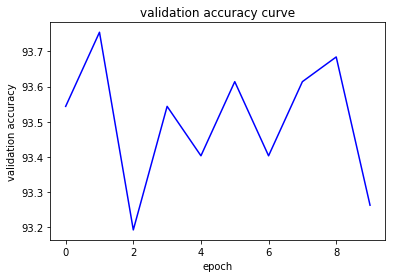

DenseNet(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(72, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (trans1): Transition(
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [40]:
fit(Densenet_model, num_epochs, optimizer, train_loader, valid_loader, device)

## 7. 加载test集数据，使用已训练的模型预测结果

### 7.1. 通过路径加载图片

In [41]:
from PIL import Image
def testImageLoader(image_name, test_trans):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
    image = image.unsqueeze(0)     
    return image  

### 7.2. 预测测试集结果形式

In [42]:
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet


### 7.3. 预测函数

In [43]:
def predict(model, transform, sample_submission, device):
    model = model.to(device)
    model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
    
    test_dir = './data/test'
    
    for index, row in (sample_submission.iterrows()):
        currImage = os.path.join(test_dir, row['file'])
        
        if os.path.isfile(currImage):
            text_img = testImageLoader (currImage, transform)
            
            text_img = text_img.to(device)
            
            # get the index of the max probability
            pro = (model(text_img)).data.max(1)[1]
            
            # get the index of classes for the predicting img
            img_index = (pro.cpu().numpy().item())
            
            # add into data frame
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(img_index)]}, ignore_index=True) 
        
    return df_pred

### 7.4. 预测结果并写入文件

In [44]:
df_pred = predict(Densenet_model, valid_trans, sample_submission, device)

In [45]:
df_pred.to_csv('./result/densenet_result4.csv', columns=('file', 'species'), index=None)

## 8. 保存模型

In [40]:
# show parameters in model

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in Densenet_model.state_dict():
    print(param_tensor, "\t", Densenet_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimzer.state_dict():
    print(var_name, "\t", optimzer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([48, 3, 3, 3])
dense1.0.bn1.weight 	 torch.Size([48])
dense1.0.bn1.bias 	 torch.Size([48])
dense1.0.bn1.running_mean 	 torch.Size([48])
dense1.0.bn1.running_var 	 torch.Size([48])
dense1.0.bn1.num_batches_tracked 	 torch.Size([])
dense1.0.conv1.weight 	 torch.Size([96, 48, 1, 1])
dense1.0.bn2.weight 	 torch.Size([96])
dense1.0.bn2.bias 	 torch.Size([96])
dense1.0.bn2.running_mean 	 torch.Size([96])
dense1.0.bn2.running_var 	 torch.Size([96])
dense1.0.bn2.num_batches_tracked 	 torch.Size([])
dense1.0.conv2.weight 	 torch.Size([24, 96, 3, 3])
dense1.1.bn1.weight 	 torch.Size([72])
dense1.1.bn1.bias 	 torch.Size([72])
dense1.1.bn1.running_mean 	 torch.Size([72])
dense1.1.bn1.running_var 	 torch.Size([72])
dense1.1.bn1.num_batches_tracked 	 torch.Size([])
dense1.1.conv1.weight 	 torch.Size([96, 72, 1, 1])
dense1.1.bn2.weight 	 torch.Size([96])
dense1.1.bn2.bias 	 torch.Size([96])
dense1.1.bn2.running_mean 	 torch.Size([96])
dense1.1.bn2.running

NameError: name 'optimzer' is not defined

In [41]:
# save model

save_path = './model/densenet_model.pt'
torch.save(Densenet_model.state_dict(), save_path)

## 9. 使用训练过的模型来初始化

In [16]:
save_path = './model/densenet_model.pt'
saved_parametes = torch.load(save_path)
args = [2, 5, 4, 6]

In [20]:
saved_parametes

OrderedDict([('conv1.weight', tensor([[[[-0.0345,  0.1512,  0.0897],
                        [ 0.1363,  0.0872, -0.0927],
                        [ 0.0553, -0.0686, -0.1253]],
              
                       [[ 0.1169,  0.0564,  0.0258],
                        [ 0.1479,  0.1153, -0.0816],
                        [ 0.0195, -0.0075, -0.0743]],
              
                       [[-0.0596,  0.1022, -0.0839],
                        [ 0.1261,  0.1735,  0.0322],
                        [ 0.1467, -0.0717, -0.1205]]],
              
              
                      [[[ 0.0348,  0.0212, -0.0749],
                        [ 0.1020,  0.1123, -0.0928],
                        [-0.1475,  0.0674,  0.1234]],
              
                       [[ 0.0729,  0.1552, -0.1425],
                        [-0.0156,  0.1813,  0.1882],
                        [-0.0360, -0.1527,  0.1540]],
              
                       [[-0.0183,  0.1310,  0.0154],
                        [ 0.1630,  0.167

In [19]:
# initailze model by saved parameters
new_model = DenseNet(Bottleneck, args)
new_model.load_state_dict(saved_parametes)

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 
	Unexpected key(s) in state_dict: "linear.weight", "linear.bias". 

#### 参考资料：
1. Week5：CNN-2
2. https://www.kaggle.com/tylercosner/pytorch-starter-pre-trained-resnet50-torchvision/notebook
3. https://www.kaggle.com/solomonk/pytorch-simplenet-augmentation-cnn-lb-0-945